<a href="https://colab.research.google.com/github/ctg123/ml-projects/blob/main/boat-image-classifier/boat_img_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.

The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows.

- Buoy
- Cruise_ship
- Ferry_boat
- Freight_boar
- Gondola
- Inflatable_boat
- Kayak
- Paper_boat
- Sailboat

Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.



## Importing Libraries

Import the necessary packages and load the dataset

In [ ]:
# Python built-in libraries
import os
from pathlib import Path

# Data pre-preprocessing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns

# Sci-kit learn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras functions
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For model training and compilation
from keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras import losses
from keras import metrics
from keras.metrics import Precision, Recall
from keras.models import save_model, load_model

# For MobileNetV2
from keras.applications import MobileNetV2

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
image_dir = Path('datasets/Automating_Port_Operations')

In [ ]:
image_dir

WindowsPath('datasets/Automating_Port_Operations')

In [ ]:
image_files = list(image_dir.glob(r'**/*.jpg'))

In order to collect the `labels` from the name of the classes,  Pathlib's `parts` attribute can directly extract the second-to-last part of the path, which corresponds to the class label.

In [ ]:
labels = [x.parts[-2] for x in image_files]

In [ ]:
image_df = pd.DataFrame({'Filepath': image_files, 'Label': labels}).astype(str).sample(frac=1.0, random_state=43).reset_index(drop=True)

image_df

,Filepath,Label
0,datasets\Automating_Port_Operations\cruise_shi...,cruise_ship
1,datasets\Automating_Port_Operations\sailboat\1...,sailboat
2,datasets\Automating_Port_Operations\sailboat\1...,sailboat
3,datasets\Automating_Port_Operations\sailboat\1...,sailboat
4,datasets\Automating_Port_Operations\gondola\15...,gondola
...,...,...
1157,datasets\Automating_Port_Operations\freight_bo...,freight_boat
1158,datasets\Automating_Port_Operations\buoy\24.jpg,buoy
1159,datasets\Automating_Port_Operations\cruise_shi...,cruise_ship
1160,datasets\Automating_Port_Operations\ferry_boat...,ferry_boat


In [ ]:
class_names = image_df['Label'].value_counts()

print(f' The number of classes found: {len(class_names)}')
print('\n')
print(class_names)

 The number of classes found: 9


Label
sailboat           389
kayak              203
gondola            193
cruise_ship        191
ferry_boat          63
buoy                53
paper_boat          31
freight_boat        23
inflatable_boat     16
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=43)

## Load the Image Data

Let's determine the image dimensions for the building the dataset and CNN architecture.

Our data is of shape `224×224` and the channel is `3(RGB)`, so for example if we are to create the first layer of a CNN, then `(224,224,3)` input shape. Hence, we used the input_shape to make sure that this layer accepts the data.

In [ ]:
train_generator = ImageDataGenerator(
	rescale=1. / 255,
    validation_split=0.2
	)

test_generator = ImageDataGenerator(rescale=1. / 255)

batch_size = 32
img_width, img_height = (224, 224)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 744 validated image filenames belonging to 9 classes.
Found 185 validated image filenames belonging to 9 classes.
Found 233 validated image filenames belonging to 9 classes.


## Visualize the Data

Here are the first `25` images from the training dataset.


In [ ]:
train_df.head(n=25)

,Filepath,Label
1028,datasets\Automating_Port_Operations\kayak\3.jpg,kayak
1026,datasets\Automating_Port_Operations\sailboat\8...,sailboat
578,datasets\Automating_Port_Operations\cruise_shi...,cruise_ship
319,datasets\Automating_Port_Operations\cruise_shi...,cruise_ship
525,datasets\Automating_Port_Operations\buoy\29.jpg,buoy
108,datasets\Automating_Port_Operations\freight_bo...,freight_boat
214,datasets\Automating_Port_Operations\sailboat\3...,sailboat
299,datasets\Automating_Port_Operations\kayak\45.jpg,kayak
658,datasets\Automating_Port_Operations\cruise_shi...,cruise_ship
1039,datasets\Automating_Port_Operations\cruise_shi...,cruise_ship


In [ ]:
# Get the image filepaths and labels from the training data
train_image_filepaths = train_df['Filepath'].values
train_labels = train_df['Label'].values

def display_examples(num_images, image_filepaths, labels):
    """
    Display the specified number of images from the images array with its corresponding labels
    """
    figsize = (20, 20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Some examples of images of the dataset", fontsize=24)

    for i in range(num_images):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Load and display the image
        img = image.imread(image_filepaths[i])
        plt.title(labels[i])
        plt.imshow(img)
        #plt.xlabel([labels[i]])
    plt.show()

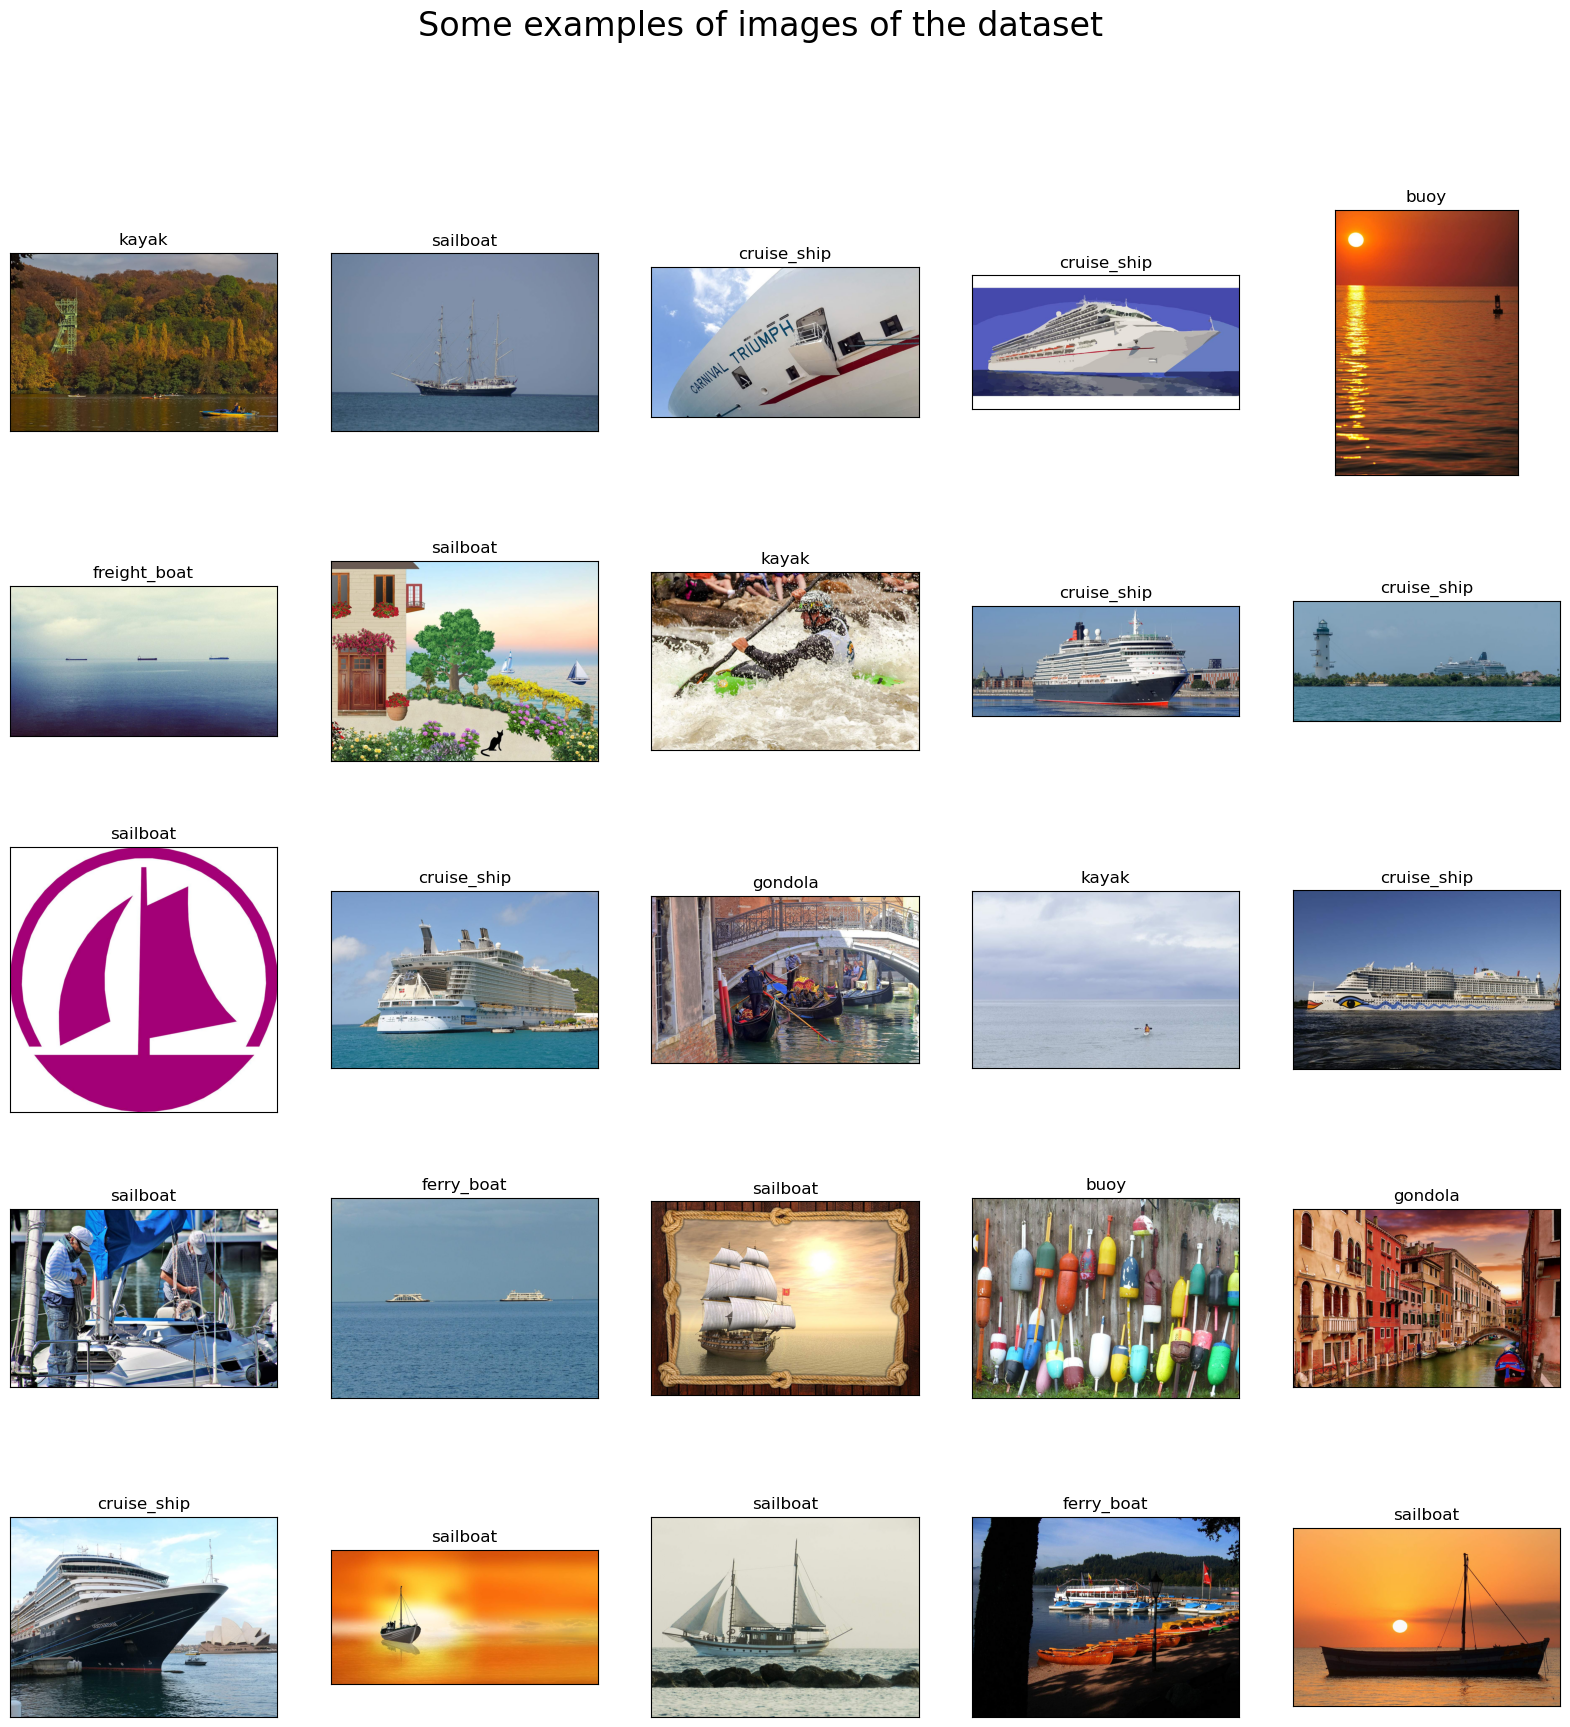

In [ ]:
display_examples(25, train_image_filepaths, train_labels)

# Section 1: Building the CNN in order to classify boats

## Build the Model

In [ ]:
channel = 3
num_classes = len(class_names)

# Adding the hidden layers and the output layer to our model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channel)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Display the summary of the model architecture and the number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                        

## Compile the Model

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy',
                Precision(),
               Recall(),
    ]
)

## Train the Model

Train the model with `20` epochs and we'll plot training loss and accuracy against epochs.

In [ ]:
# Define checkpoints
checkpoint = ModelCheckpoint('best_model.h5',
                             save_best_only= True)

In [ ]:
epochs=20

history = model.fit(
  train_images,
  validation_data=val_images,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/20
24/24 [==============================] - 15s 588ms/step - loss: 1.9544 - accuracy: 0.3253 - precision: 0.4186 - recall: 0.0484 - val_loss: 1.8501 - val_accuracy: 0.3459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 11s 459ms/step - loss: 1.8161 - accuracy: 0.3387 - precision: 0.6818 - recall: 0.0202 - val_loss: 1.8224 - val_accuracy: 0.3459 - val_precision: 1.0000 - val_recall: 0.0108
Epoch 3/20
24/24 [==============================] - 11s 463ms/step - loss: 1.8072 - accuracy: 0.3387 - precision: 1.0000 - recall: 0.0027 - val_loss: 1.8174 - val_accuracy: 0.3459 - val_precision: 1.0000 - val_recall: 0.0270
Epoch 4/20
24/24 [==============================] - 11s 472ms/step - loss: 1.8023 - accuracy: 0.3387 - precision: 1.0000 - recall: 0.0054 - val_loss: 1.8065 - val_accuracy: 0.3459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
24/24 [==============================] - 11s 457ms/step - loss: 1.7883 - 

In [ ]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the CNN.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

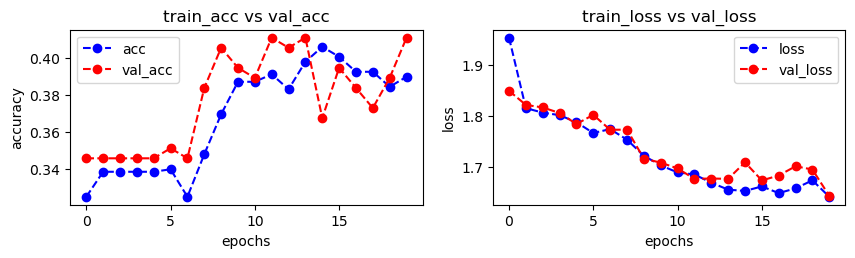

In [ ]:
plot_accuracy_loss(history)

## Evaluate the Model

In [ ]:
best_model = save_model(model, "best_model.h5")

In [ ]:
# Load the model, including both architecture and weights
saved_model = load_model('best_model.h5')

results = saved_model.evaluate(test_images)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f} %")
print(f"Test Precision: {results[2]*100:.2f} %")

8/8 [==============================] - 2s 269ms/step - loss: 1.6505 - accuracy: 0.3820 - precision: 0.5439 - recall: 0.1330
Test Loss: 1.6505
Test Accuracy: 38.20 %
Test Precision: 54.39 %


## Plot Heatmap of the Confusion Matrix and Print Classification Report

8/8 [==============================] - 2s 172ms/step


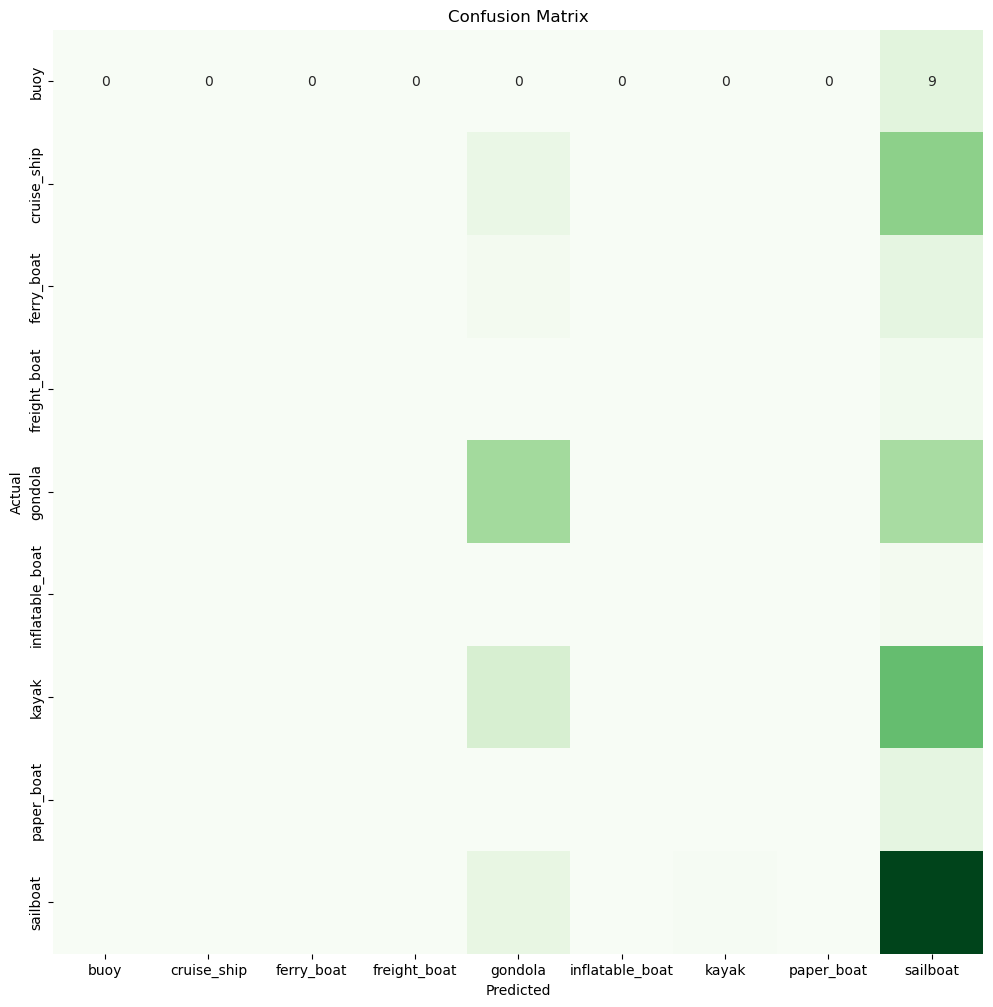



Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.00      0.00      0.00         9
    cruise_ship       0.00      0.00      0.00        34
     ferry_boat       0.00      0.00      0.00        10
   freight_boat       0.00      0.00      0.00         3
        gondola       0.47      0.51      0.49        47
inflatable_boat       0.00      0.00      0.00         2
          kayak       0.00      0.00      0.00        47
     paper_boat       0.00      0.00      0.00         8
       sailboat       0.36      0.89      0.51        73

       accuracy                           0.38       233
      macro avg       0.09      0.16      0.11       233
   weighted avg       0.21      0.38      0.26       233



In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
report = classification_report(test_images.labels, predictions, target_names=list(train_images.class_indices.keys()))

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print("Classification Report:\n----------------------\n", report)

# Section 2: Transfer Learning via MobileNetV2

## Create a new dataset to use with the MobileNetV2 pre-trained model

In [ ]:
mn_train_df, mn_test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

## Load the Image Data

In [ ]:
mn_train_generator = ImageDataGenerator(
	rescale=1. / 255,
    validation_split=0.2
	)

mn_test_generator = ImageDataGenerator(rescale=1. / 255)

batch_size = 32
img_width, img_height = (224, 224)

In [ ]:
mn_train_images = train_generator.flow_from_dataframe(
    dataframe=mn_train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    subset='training'
)

mn_val_images = train_generator.flow_from_dataframe(
    dataframe=mn_train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    subset='validation'
)


mn_test_images = test_generator.flow_from_dataframe(
    dataframe=mn_test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 651 validated image filenames belonging to 9 classes.
Found 162 validated image filenames belonging to 9 classes.
Found 349 validated image filenames belonging to 9 classes.


## Build the Model

In [ ]:
channel = 3
num_classes = len(class_names)

# Load MobileNetV2 - Light Model
mn_v2_light = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_width, img_height, channel))

# Create a Sequential model
mn_model = Sequential()

# Add MobileNetV2 as the first layer
mn_model.add(mn_v2_light)

# Add other layers
mn_model.add(GlobalAveragePooling2D())
mn_model.add(Dropout(0.2))
mn_model.add(Dense(256, activation='relu'))
mn_model.add(BatchNormalization())
mn_model.add(Dropout(0.1))
mn_model.add(Dense(128, activation='relu'))
mn_model.add(BatchNormalization())
mn_model.add(Dropout(0.1))
mn_model.add(Dense(128, activation='relu'))
mn_model.add(Dense(128, activation='relu'))
mn_model.add(Dense(num_classes, activation='softmax'))

# Display the summary of the model architecture and the number of parameters
mn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                      

## Compile the Model

In [ ]:
mn_model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy',
                Precision(),
               Recall(),
    ]
)

## Train the Model

Train the model with `50` epochs and we'll plot training loss and accuracy against epochs. We want to monitor the validation loss at each epoch and after the validation loss has not improved after two epochs, training is interrupted.

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

# Define checkpoints
checkpoint = ModelCheckpoint('best_mn_model.h5',
                             save_best_only= True,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

In [ ]:
epochs=50

# Train the model with early stopping and model checkpointing
history = mn_model.fit(
    mn_train_images,
    epochs=epochs,
    validation_data=mn_val_images,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5019 - accuracy: 0.5376 - precision_1: 0.7368 - recall_1: 0.3011
Epoch 1: val_loss improved from inf to 1.99182, saving model to best_mn_model.h5
21/21 [==============================] - 50s 2s/step - loss: 1.5019 - accuracy: 0.5376 - precision_1: 0.7368 - recall_1: 0.3011 - val_loss: 1.9918 - val_accuracy: 0.3272 - val_precision_1: 0.3358 - val_recall_1: 0.2840
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.8163 - accuracy: 0.7419 - precision_1: 0.8577 - recall_1: 0.6575
Epoch 2: val_loss did not improve from 1.99182
21/21 [==============================] - 38s 2s/step - loss: 0.8163 - accuracy: 0.7419 - precision_1: 0.8577 - recall_1: 0.6575 - val_loss: 2.9079 - val_accuracy: 0.3395 - val_precision_1: 0.3462 - val_recall_1: 0.3333
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.7773 - precision_1: 0.8750 - recall_1: 0.6989
Epoch 3: val_loss did not imp

In [ ]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the CNN.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

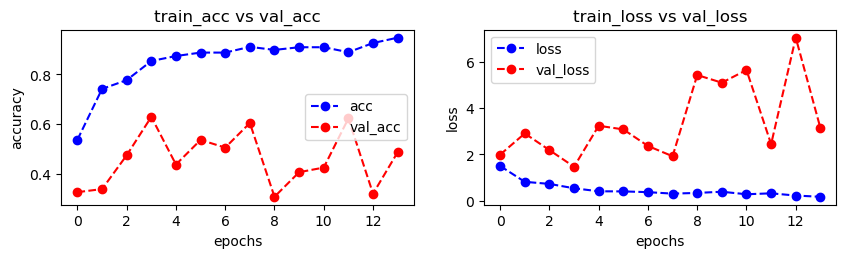

In [ ]:
plot_accuracy_loss(history)

## Evaluate the Model

In [ ]:
best_model = save_model(mn_model, "best_mn_model.h5")

In [ ]:
# Load the model, including both architecture and weights
saved_model = load_model('best_mn_model.h5')

results = saved_model.evaluate(mn_test_images)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f} %")
print(f"Test Precision: {results[2]*100:.2f} %")

11/11 [==============================] - 5s 326ms/step - loss: 1.4190 - accuracy: 0.6562 - precision_1: 0.7148 - recall_1: 0.6103
Test Loss: 1.4190
Test Accuracy: 65.62 %
Test Precision: 71.48 %


# Section 3: Conclusion

In this project, we explored two approaches for boat classification: a custom Convolutional Neural Network (CNN) and Transfer Learning with MobileNetV2. Here are the key takeaways:

- **Model Comparison**:
  - The custom CNN (Model 1) was built from scratch for boat classification.
  - Transfer Learning with MobileNetV2 (Model 2) used a pre-trained model for feature extraction.

- **Model Performance**:
  - Both models did not achieve accuracy above 80% when evaluating the test images.
  - Notably, Model 2 (MobileNetV2 with transfer learning) exhibited a significant gap between its training and test accuracy, indicating a potential issue with overfitting.

- **Challenges for Accuracy**:
  - The inability to surpass the 80% accuracy threshold may be attributed to:
    - Class Imbalance: Variations in the number of examples across boat types.
    - Limited Data: A relatively small dataset, which may lead to overfitting.
    - Complex Task: Boat classification requires capturing nuanced features.
  
- **Recommendations**:
  - Address class imbalance with techniques like data augmentation, oversampling, or class weights.
  - Consider collecting more labeled data, especially for minority classes.
  - Fine-tune model architectures and hyperparameters to reduce overfitting.

In conclusion, while both models fell short of achieving accuracy above `80%`, the more significant disparity in training and test accuracy observed in Model 2 indicates a potential overfitting issue. This project lays the groundwork for further refinement and optimization of boat classification models.